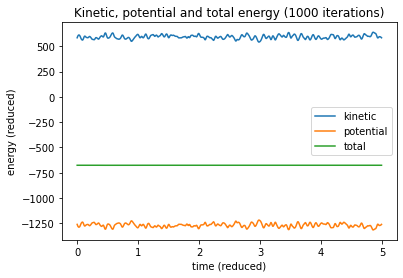

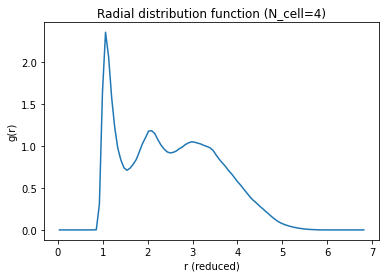

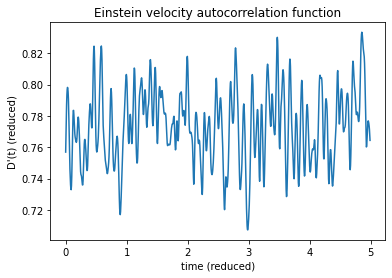

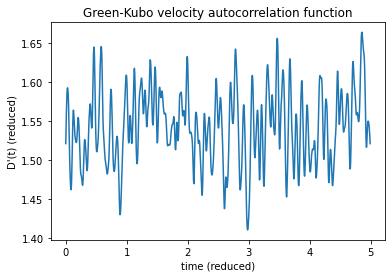

Average Einstein diffusion coefficient 3.863987376353127
Average Green-Kubo diffusion coefficient 7.710834963025418
Ratio 1.9955642221334033


In [185]:
#!/usr/bin/env python3
'''
MD simulation of Lennard-Jones fluids
modified from
https://github.com/basnijholt/molecular-dynamics-Python/blob/master/MD.ipynb
The original code is wrong. If you simply copy it, you will get ZERO mark!
Reduced unit: \sigma=\epsilon=mass=k_B=1

###### create ./images folder before running this code ######
'''

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
from itertools import product

sigma = 34.05  # nm
t0 = 2.157  # ps
n_bins = 100

T_0 = 1.50  # temperature
rho = 0.7976  # density of Argon in reduced units
# T_0 = 0.71  # temperature
# rho = 0.844  # density of Argon in reduced units

n_frames = 1000
dt = 5/n_frames  # time step size
N_cell = 4  # number of fcc unitcells in one direction
N = 4 * N_cell ** 3  # the total number of particles in the system
L_box = (N / rho) ** (1 / 3.0)  # length of the whole simulation box
L_cell = L_box / N_cell  # length of a unitcell
F = np.zeros((N, N, 3))  # matrix that contains all forces
ind = np.triu_indices(N, k=1)  # indices of upper triangular matrix


def IC_pos(N_cell, L_cell):
    '''
    use fcc structure to initilize positions
    '''
    pos = [[[x,  y, z],
            [x, 0.5 + y, 0.5 + z],
            [0.5 + x, y, 0.5 + z],
            [0.5 + x, 0.5 + y, z]]
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    pos = np.array(pos).reshape((-1, 3))
    return pos * L_cell


def IC_vel(N):
    '''
    Maxwell-Boltzman distribution is a normal distribution
    '''
    vel = np.sqrt(T_0) * np.random.randn(N, 3)
    vel -= np.average(vel, axis=0)
    return vel


def find_force(pos, L_box=L_box):
    '''
    Minimum image convention. 
    '''
    r_vec = pos[ind[0]] - pos[ind[1]]
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box
    r_sq = np.sum(r_vec**2, axis=1)
    F_vec = -(48 / r_sq ** 7 - 24 / r_sq ** 4)[:, None] * r_vec
    F[ind[0], ind[1]] = F_vec
    pot = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)
    P = np.sum(F_vec * r_vec)
    return np.sum(F, axis=0) - np.sum(F, axis=1), pot, P


def time_step(pos, vel, F):
    vel += 0.5 * F * dt
    pos = pos + vel * dt
    pos_folded = np.mod(pos, L_box)
    # pos = np.mod(pos + vel * dt, L_box) # why both pos and pos_folded?
    F, pot, P = find_force(pos_folded)

    vel += 0.5 * F * dt
    kin = 0.5 * np.sum(vel**2)
    return pos, vel, F, pot, kin, P


def min_dist(r):
    if r > L_box/2:
        return r - L_box
    elif r < -L_box/2:
        return r + L_box
    else:
        return r


def simulate(f, h_r, bins, drs, dvs):
    kins, pots, Ps = [], [], []
    pos = IC_pos(N_cell, L_cell)
    prev_pos = pos
    vel = IC_vel(N)
    prev_vel = vel
    dr, dv = 0, 0
    F = find_force(pos)[0]
    for i in range(2*n_frames):
        pos, vel, F, pot, kin, P = time_step(pos, vel, F)
        if i > n_frames:  # production run
            kins.append(kin)
            pots.append(pot)
            Ps.append(P)

            SI_pos = pos*sigma
            SI_vel = vel*sigma/t0

            f.write('MD of 1 Argon t=%10.5f\n' % (i * dt * t0))
            f.write('%5d\n' % (N))
            for j in range(N):
                f.write('%5d%-5s%5s%5d%8.3f%8.3f%8.3f%8.4f%8.4f%8.4f\n' %
                        (j, 'ARGON', 'Ar', j,
                         SI_pos[j][0], SI_pos[j][1], SI_pos[j][2],
                         SI_vel[j][0], SI_vel[j][1], SI_vel[j][2]))
            f.write('%10.5f%10.5f%10.5f\n' %
                    (L_box*sigma, L_box*sigma, L_box*sigma))

            r_vec = pos[ind[0]] - pos[ind[1]]
            r_vec = r_vec - np.rint(r_vec / L_box) * L_box
            r_sq = np.sum(r_vec**2, axis=1)
            h_r += np.histogram(np.sqrt(r_sq), bins)[0]

            drs.append(np.average(np.sum((pos-prev_pos)**2, axis=1)))
            dvs.append(np.average(np.sum((vel*prev_vel), axis=1)))
        else:  # equillirum run
            vel *= np.sqrt(N * 3 * T_0 / (2 * kin))
        prev_pos = pos
        prev_vel = vel

    return np.array(kins), np.array(pots), np.array(Ps)


# The simulation starts here
if __name__ == "__main__":
    h_r = np.zeros(n_bins)
    bins = np.linspace(0, L_box, n_bins+1)

    drs = []
    dvs = []

    with open('argon.gro', 'w') as f:
        kins, pots, Ps = simulate(f, h_r, bins, drs, dvs)
    times = np.arange(len(kins)) * dt
    T = np.mean(kins * 2 / (3 * N))  # temperature
    P = 1 - np.mean(Ps) / (3 * N * T) - 16 * np.pi * \
        rho / (3 * T * L_box**3)  # compressibility factor
    P = P * T * rho  # pressure here
    # print(T, P)  # how about thermal fluctuation?
    # print(pots)

    # plot the energy vs time results
    plt.plot(times, kins)
    plt.plot(times, pots)
    plt.plot(times, kins+pots)
    plt.legend(['kinetic', 'potential', 'total'])
    plt.xlabel('time (reduced)')
    plt.ylabel('energy (reduced)')
    plt.title(f'Kinetic, potential and total energy ({n_frames} iterations)')
    plt.savefig('images/energy.png')
    plt.show()

    n_r = (h_r*2/((N-1)*(n_frames-1)))
    g_r = n_r/(4/3*pi*((bins[1:])**3 - (bins[:-1])**3)*rho)
    plt.plot(bins[:n_bins]+(bins[1]-bins[0])/2, g_r)
    plt.title(f'Radial distribution function (N_cell={N_cell})')
    plt.savefig(f'images/g_r(N_cell={N_cell}).png')
    plt.xlabel('r (reduced)')
    plt.ylabel('g(r)')
    plt.show()

    V_ac_einstein = np.array(drs)/(6*dt**2)
    V_ac_gkb = np.array(dvs)/3

    D_einstein = np.sum(V_ac_einstein)*dt
    D_gkb = np.sum(V_ac_gkb)*dt
    plt.plot(times, V_ac_einstein)
    plt.title('Einstein velocity autocorrelation function')
    plt.xlabel('time (reduced)')
    plt.ylabel('D\'(t) (reduced)')
    plt.savefig('images/V_ac_einstein.png')
    plt.show()

    plt.plot(times, V_ac_gkb)
    plt.title('Green-Kubo velocity autocorrelation function')
    plt.xlabel('time (reduced)')
    plt.ylabel('D\'(t) (reduced)')
    plt.savefig('images/V_ac_gkb.png')
    plt.show()

    print('Average Einstein diffusion coefficient', D_einstein)
    print('Average Green-Kubo diffusion coefficient', D_gkb)
    print('Ratio', D_gkb/D_einstein)

In [181]:
sum(h_r)/(N-1)/(n_frames-1)*2 == N

True

In [159]:
L_box/2

2.5675340258627344